## Training Data 

OCHA SERVICES DATA: This dataset is a detailed dataset containing data regarding the many different services and 

amenities available in Kenya, and the date when they were recorded. We will use this data in training our model to 

identify the specific service or amenity a resident wants improved. Below is the link to the dataset:

PPRA Awarded contracts - Kenya - This dataset shows the tenders awarded to various organizations and the services 

they offered in 2019. We will use this data to train our model in identifying the services a user feels should be 

improved .

Settled on the approach of combining the  two primary data sources first and then performing preprocessing on the 

combined dataset.

In [114]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import spacy
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
import string
import gensim
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nlp = spacy.load('en_core_web_sm')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [115]:
#ocha dataset
ocha_dataset=pd.read_csv("infrastructure_ken.csv")
ocha_dataset.head(10)

,Country Name,Country ISO3,Year,Indicator Name,Indicator Code,Value
0,#country+name,#country+code,#date+year,#indicator+name,#indicator+code,#indicator+value+num
1,Kenya,KEN,2021,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,973328921.924682
2,Kenya,KEN,2020,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,567129881.228679
3,Kenya,KEN,2019,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,628827610.941533
4,Kenya,KEN,2018,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,570245522.266492
5,Kenya,KEN,2017,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,473090014.312925
6,Kenya,KEN,2016,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,451360165.698429
7,Kenya,KEN,2015,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,550307434.561937
8,Kenya,KEN,2014,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,755711724.114998
9,Kenya,KEN,2013,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,515175648.649776


In [116]:
ocha_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country Name    1340 non-null   object
 1   Country ISO3    1340 non-null   object
 2   Year            1340 non-null   object
 3   Indicator Name  1340 non-null   object
 4   Indicator Code  1340 non-null   object
 5   Value           1340 non-null   object
dtypes: object(6)
memory usage: 62.9+ KB


In [117]:
ocha_dataset.columns

Index(['Country Name', 'Country ISO3', 'Year', 'Indicator Name',
       'Indicator Code', 'Value'],
      dtype='object')

In [118]:
ocha_dataset.drop(0, inplace=True)
ocha_dataset.head()

,Country Name,Country ISO3,Year,Indicator Name,Indicator Code,Value
1,Kenya,KEN,2021,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,973328921.924682
2,Kenya,KEN,2020,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,567129881.228679
3,Kenya,KEN,2019,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,628827610.941533
4,Kenya,KEN,2018,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,570245522.266492
5,Kenya,KEN,2017,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,473090014.312925


In [119]:
year_counts=ocha_dataset['Year'].value_counts()
year_counts

Year
2009    45
2008    44
2007    42
2004    42
2010    41
        ..
1964     2
1963     2
1962     2
1961     2
1960     2
Name: count, Length: 63, dtype: int64

In [120]:
# Get the most common service across all years
most_common_activity = ocha_dataset['Indicator Name'].mode()[0]
most_common_activity

'Renewable internal freshwater resources per capita (cubic meters)'

In [121]:
# Group the data by 'Year' and find the most common services for each year
most_common_activities = ocha_dataset.groupby('Year')['Indicator Name'].agg(lambda x: x.mode().iloc[0]).reset_index()
most_common_activities.head(10)

,Year,Indicator Name
0,1960,Mobile cellular subscriptions
1,1961,Renewable internal freshwater resources per ca...
2,1962,Renewable internal freshwater resources per ca...
3,1963,Renewable internal freshwater resources per ca...
4,1964,Renewable internal freshwater resources per ca...
5,1965,Fixed telephone subscriptions
6,1966,Fixed telephone subscriptions
7,1967,Fixed telephone subscriptions
8,1968,Fixed telephone subscriptions
9,1969,Fixed telephone subscriptions


In [122]:
#Most Common activities in the past 10 years
most_common_activities.tail(10)

,Year,Indicator Name
53,2013,"Air transport, freight (million ton-km)"
54,2014,"Air transport, freight (million ton-km)"
55,2015,"Air transport, freight (million ton-km)"
56,2016,"Air transport, freight (million ton-km)"
57,2017,"Air transport, freight (million ton-km)"
58,2018,"Air transport, freight (million ton-km)"
59,2019,"Air transport, freight (million ton-km)"
60,2020,"Air transport, freight (million ton-km)"
61,2021,"Air transport, freight (million ton-km)"
62,2022,Fixed broadband subscriptions


Plotting  Graph for the most common services provided in the last 10 years

c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

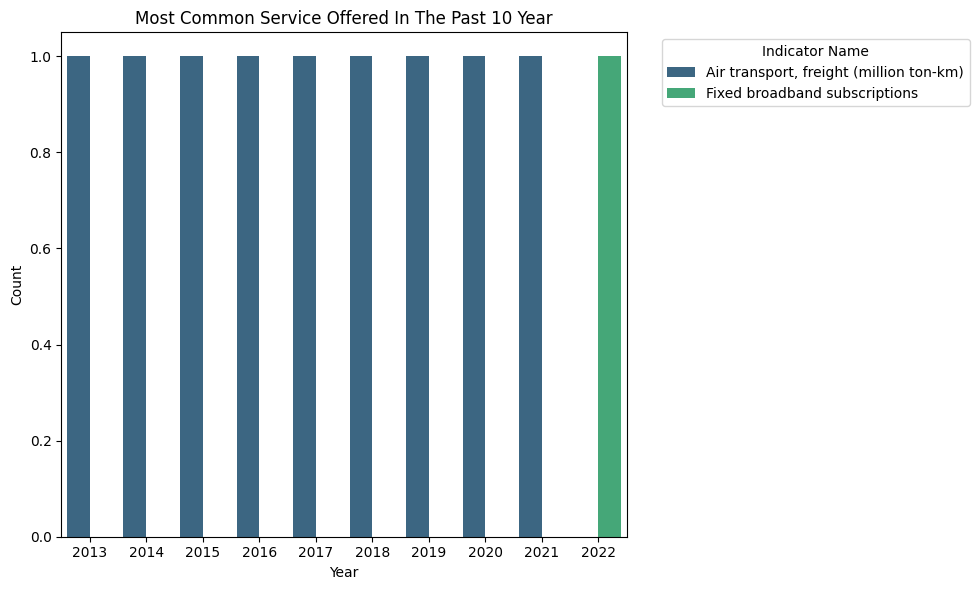

In [123]:
plt.figure(figsize=(10, 6))
sns.countplot(data=most_common_activities.tail(10), x='Year', hue='Indicator Name', palette='viridis', dodge=True)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Most Common Service Offered In The Past 10 Year')
plt.legend(title='Indicator Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [124]:
ocha_dataset['Year']=pd.to_numeric(ocha_dataset['Year'],errors='coerce')
years=ocha_dataset['Year']
describe_stats=years.describe()
describe_stats

count    1339.000000
mean     1999.887229
std        14.007685
min      1960.000000
25%      1991.000000
50%      2002.000000
75%      2010.000000
max      2022.000000
Name: Year, dtype: float64

c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<function matplotlib.pyplot.show(close=None, block=None)>

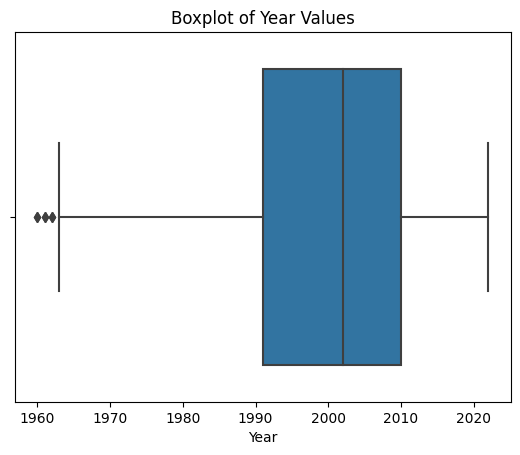

In [125]:
#checking for outliers in the dataset
sns.boxplot(x=years)

#display the plot 
plt.xlabel('Year')
plt.title('Boxplot of Year Values')
plt.show

In [126]:
ocha_dataset.head()

,Country Name,Country ISO3,Year,Indicator Name,Indicator Code,Value
1,Kenya,KEN,2021,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,973328921.924682
2,Kenya,KEN,2020,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,567129881.228679
3,Kenya,KEN,2019,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,628827610.941533
4,Kenya,KEN,2018,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,570245522.266492
5,Kenya,KEN,2017,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,473090014.312925


Data Pre-processing

In [127]:
#make copy of original dataset
ocha_clean=ocha_dataset.copy()

In [128]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

In [129]:
# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the text data
ocha_clean['Indicator Name']= ocha_clean['Indicator Name'].apply(lambda x:expand_contractions(x))

In [130]:
ocha_clean['Indicator Name'].head()

1    ICT service exports (BoP, current US$)
2    ICT service exports (BoP, current US$)
3    ICT service exports (BoP, current US$)
4    ICT service exports (BoP, current US$)
5    ICT service exports (BoP, current US$)
Name: Indicator Name, dtype: object

In [131]:
#removing stopwords
stop_words = set(stopwords.words('english')) 

def remove_stopwords(article):
    "Return the article after remvoing stopwords"
    article_tokens = word_tokenize(article) 
    filtered_article = [word for word in article_tokens if not word in stop_words] 
    return " ".join(filtered_article)


#removing stopwords
ocha_clean['Indicator Name'] = ocha_clean['Indicator Name'].apply(remove_stopwords)

In [132]:
ocha_clean['Indicator Name'].head()

1    ICT service exports ( BoP , current US $ )
2    ICT service exports ( BoP , current US $ )
3    ICT service exports ( BoP , current US $ )
4    ICT service exports ( BoP , current US $ )
5    ICT service exports ( BoP , current US $ )
Name: Indicator Name, dtype: object

In [133]:
print(f"These are the pucntions which string.punctuation consist :  {string.punctuation}")

These are the pucntions which string.punctuation consist :  !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [134]:
# Remove punctuations
ocha_clean['Indicator Name'] = ocha_clean['Indicator Name'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

# Remove digits
ocha_clean['Indicator Name'] = ocha_clean['Indicator Name'].apply(lambda x: re.sub(r'\d+', '', x))

In [135]:
ocha_clean['Indicator Name']

1       ICT service exports  BoP  current US  
2       ICT service exports  BoP  current US  
3       ICT service exports  BoP  current US  
4       ICT service exports  BoP  current US  
5       ICT service exports  BoP  current US  
                         ...                  
1335          Personal computers  per  people 
1336          Personal computers  per  people 
1337          Personal computers  per  people 
1338          Personal computers  per  people 
1339          Personal computers  per  people 
Name: Indicator Name, Length: 1339, dtype: object

In [136]:
def lemmatize(text):
    """Return text after performing the lemmztiztion"""
    doc = nlp(text)
    tokens = [token for token in doc]
    return  " ".join([token.lemma_ for token in doc])

#lemmatize the articles
ocha_clean['Indicator Name'] = ocha_clean['Indicator Name'].apply(lemmatize)

In [137]:
ocha_clean['Indicator Name']

1       ICT service export   bop   current US  
2       ICT service export   bop   current US  
3       ICT service export   bop   current US  
4       ICT service export   bop   current US  
5       ICT service export   bop   current US  
                         ...                   
1335           personal computer   per   people
1336           personal computer   per   people
1337           personal computer   per   people
1338           personal computer   per   people
1339           personal computer   per   people
Name: Indicator Name, Length: 1339, dtype: object

In [138]:
def remove_custom_words(sentence, custom_words):
    words = sentence.split()
    filtered_words = [word for word in words if word.lower() not in custom_words]
    return ' '.join(filtered_words)


# Custom words to remove
custom_words_list = ['people', 'service', 'per', 'bop', 'current','withdrawal','resources','capita','private','participation','partnership','total','nonresident','count','resident','worldwide''passengers''index','cubic','meter','internal',
                     'annual','billion']

ocha_clean['Indicator Name'] = ocha_clean['Indicator Name'].apply(lambda x: remove_custom_words(x, custom_words_list))


In [139]:
ocha_clean['Indicator Name']

1           ICT export US
2           ICT export US
3           ICT export US
4           ICT export US
5           ICT export US
              ...        
1335    personal computer
1336    personal computer
1337    personal computer
1338    personal computer
1339    personal computer
Name: Indicator Name, Length: 1339, dtype: object

In [140]:
# Define the function to convert text to lowercase
def convert_to_lower(text):
    return text.lower()

ocha_clean['Indicator Name'] = ocha_clean['Indicator Name'].apply(convert_to_lower)

In [141]:
ocha_clean['Indicator Name'] 

1           ict export us
2           ict export us
3           ict export us
4           ict export us
5           ict export us
              ...        
1335    personal computer
1336    personal computer
1337    personal computer
1338    personal computer
1339    personal computer
Name: Indicator Name, Length: 1339, dtype: object

In [142]:
# Function to remove words with fewer than 3 characters
def remove_short_words(sentence):
    words = sentence.split()
    filtered_words = [word for word in words if len(word) >= 3]
    return ' '.join(filtered_words)

# Apply the function to the 'Text_Column' using .apply()
ocha_clean['Indicator Name'] = ocha_clean['Indicator Name'].apply(remove_short_words)

In [143]:
ocha_clean['Indicator Name'] 

1              ict export
2              ict export
3              ict export
4              ict export
5              ict export
              ...        
1335    personal computer
1336    personal computer
1337    personal computer
1338    personal computer
1339    personal computer
Name: Indicator Name, Length: 1339, dtype: object

In [144]:
# Function to remove extra whitespaces
def remove_extra_whitespaces(sentence):
    # Replace multiple spaces with a single space using regex
    sentence = re.sub(r'\s+', ' ', sentence)
    # Strip leading and trailing spaces
    sentence = sentence.strip()
    return sentence

# Apply the function to the 'Text_Column' using .apply()
ocha_clean['Indicator Name'] = ocha_clean['Indicator Name'].apply(remove_extra_whitespaces)

In [145]:
ocha_clean['Indicator Name']

1              ict export
2              ict export
3              ict export
4              ict export
5              ict export
              ...        
1335    personal computer
1336    personal computer
1337    personal computer
1338    personal computer
1339    personal computer
Name: Indicator Name, Length: 1339, dtype: object

In [146]:
ocha_clean['Indicator Name'].head()

1    ict export
2    ict export
3    ict export
4    ict export
5    ict export
Name: Indicator Name, dtype: object

c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


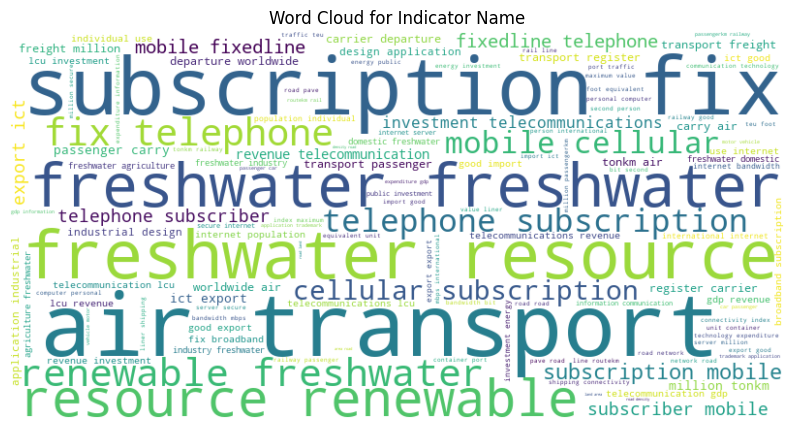

In [147]:
import wordcloud
from wordcloud import WordCloud

# Join all text in the 'Text_Column' into a single string
text = ' '.join(ocha_clean['Indicator Name'].tolist())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Indicator Name')
plt.show()

In [148]:
#topic modelling
#tokenize articles
tokeize_article = ocha_clean['Indicator Name'].apply(lambda x : x.split())
id2word = corpora.Dictionary(tokeize_article)

# Create Corpus
texts = tokeize_article

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


#printing 50 words from the text corpus
corpus_example = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]
corpus_example[0][:50]

[('export', 1), ('ict', 1)]

In [149]:
#build LDA model for 10 topic
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           per_word_topics=True,
                                           eta = 0.6)

In [150]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.255*"telecommunication" + 0.255*"revenue" + 0.123*"freshwater" + 0.117*"lcu" + 0.062*"resource" + 0.051*"renewable" + 0.027*"gdp" + 0.011*"industry" + 0.010*"domestic" + 0.009*"agriculture"'), (1, '0.221*"passenger" + 0.159*"carry" + 0.082*"household" + 0.082*"television" + 0.065*"car" + 0.055*"railway" + 0.037*"million" + 0.034*"passengerkm" + 0.006*"air" + 0.006*"transport"'), (2, '0.150*"good" + 0.098*"internet" + 0.089*"export" + 0.084*"ict" + 0.069*"import" + 0.058*"population" + 0.058*"individual" + 0.058*"use" + 0.045*"technology" + 0.045*"communication"'), (3, '0.365*"personal" + 0.365*"computer" + 0.104*"broadband" + 0.010*"trademark" + 0.003*"fix" + 0.002*"subscription" + 0.002*"application" + 0.002*"gdp" + 0.002*"household" + 0.002*"television"'), (4, '0.212*"transport" + 0.178*"air" + 0.116*"million" + 0.086*"tonkm" + 0.063*"freight" + 0.053*"departure" + 0.053*"carrier" + 0.053*"worldwide" + 0.053*"register" + 0.002*"public"'), (5, '0.239*"fixedline" + 0.239*"subsc

In [151]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.138536  0.285907       1        1  17.428972
4     -0.067945 -0.113853       2        1  15.686518
6      0.321147  0.027260       3        1  14.169723
2     -0.074818 -0.168150       4        1  13.198710
9     -0.131703  0.284391       5        1   9.579257
5      0.382504  0.053939       6        1   7.696904
8     -0.090305 -0.109225       7        1   6.864967
7     -0.073423 -0.078505       8        1   6.536404
1     -0.078227 -0.097571       9        1   5.454529
3     -0.048695 -0.084194      10        1   3.384017, topic_info=                 Term        Freq       Total Category  logprob  loglift
47       subscription  215.000000  215.000000  Default  30.0000  30.0000
81  telecommunication  208.000000  208.000000  Default  29.0000  29.0000
80            revenue  261.000000  261.000000  Default  28.0000  28.0000
49          telephone  192.000000  192.000000  Default  27.0000  27.0000
9          investment  126.000000  126.000000  Default  26.0000  26.0000
..                ...         ...         ...      ...      ...      ...
82          fixedline    0.284209   90.234870  Topic10  -6.2975  -2.3744
83         subscriber    0.284209   90.234870  Topic10  -6.2975  -2.3744
52             secure    0.284208   30.135423  Topic10  -6.2975  -1.2776
53             server    0.284208   30.135423  Topic10  -6.2975  -1.2776
22            million    0.284207   97.579203  Topic10  -6.2975  -2.4526

[499 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2         1  0.567231  agriculture
2         2  0.081033  agriculture
2         3  0.081033  agriculture
2         4  0.081033  agriculture
2         5  0.081033  agriculture
...     ...       ...          ...
20        3  0.023172    worldwide
20        4  0.023172    worldwide
20        5  0.023172    worldwide
20        8  0.023172    worldwide
20        9  0.023172    worldwide

[644 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 7, 3, 10, 6, 9, 8, 2, 4])

In [152]:
from gensim.models.coherencemodel import CoherenceModel
#measure how good our model is
# Compute Perplexity
print('\nPerplexity : ', lda_model.log_perplexity(corpus)) 

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokeize_article, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity :  -3.59340309180483

Coherence Score:  0.5772378755846355


Tuning hyperparameters:
We can try out different number of topics, different values of alpha and beta(eta) to increse the conharence score. High conherence score is good for our model.

In [153]:
def calculate_coherence_score(n, alpha, beta):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           per_word_topics=True,
                                           eta = beta)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokeize_article, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda



PPRA DATA

In [154]:
#ppra contracts
ppra=pd.read_csv('ke_contracts.csv')
ppra.head()

,id,tender-title,tender-ref_No,contract_amount,contract_code,contract_status,created_at,expected_completion_date,month,org_name,pin_number,supplier_name,tender_award_date,type,updated_at,year
0,0,provision of security services.,NTZDC/TN/03/2018/19/20,"4,852,800.00",MZ4BVH7F,Ongoing,2019-03-11 16:02:26,2019-12-31,Dec,Nyayo Tea Zones Develop Corporation,P051165790I,kleen homes security services limited,2019-12-24,State Corporation,8 Months,2019
1,1,supply and delivery of office safe and bookshe...,KFS/038/2018-2019,"42,000.00",VV12D2BJ,Ongoing,2019-01-30 11:24:19,2019-02-15,Dec,Kenya Forest Service,P051540293F,ample express general supplies,2019-12-24,State Corporation,0 Days,2019
2,2,supply of safety shoes,RFX7702,"40,728.00",R1I9USRQ,Ongoing,2019-01-14 15:25:17,2019-01-04,Dec,Kenya Airport Authority,P051143344Z,zocom limited,2019-12-05,State Corporation,0 Days,2019
3,3,supply and delivery of promotional items,GDC/HQS/RFQ/015/2018-2019,"97,257.00",NMFBVWNJ,Ongoing,2019-02-05 11:39:49,2019-01-28,Dec,Geothermal Development Company,P051546295V,tremit enterprises,2019-12-05,State Corporation,0 Days,2019
4,4,supply and delivery of airtime,EACC/25/2018-2019,"940,000.00",HBI8BFUZ,Ongoing,2019-01-28 15:44:25,2019-01-08,Nov,Ethics and Anti-Corruption Commission,P051129820X,safaricom plc,2019-11-30,Commissions and Independent Offices,0 Days,2019


In [155]:
ppra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4155 entries, 0 to 4154
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        4155 non-null   int64 
 1   tender-title              4155 non-null   object
 2   tender-ref_No             4155 non-null   object
 3   contract_amount           4155 non-null   object
 4   contract_code             4155 non-null   object
 5   contract_status           4155 non-null   object
 6   created_at                4155 non-null   object
 7   expected_completion_date  4155 non-null   object
 8   month                     4155 non-null   object
 9   org_name                  4155 non-null   object
 10  pin_number                4155 non-null   object
 11  supplier_name             4154 non-null   object
 12  tender_award_date         4155 non-null   object
 13  type                      4155 non-null   object
 14  updated_at              

In [156]:
ppra.columns

Index(['id', 'tender-title', 'tender-ref_No', 'contract_amount',
       'contract_code', 'contract_status', 'created_at',
       'expected_completion_date', 'month', 'org_name', 'pin_number',
       'supplier_name', 'tender_award_date', 'type', 'updated_at', 'year'],
      dtype='object')

In [157]:
ppra.head(10)

,id,tender-title,tender-ref_No,contract_amount,contract_code,contract_status,created_at,expected_completion_date,month,org_name,pin_number,supplier_name,tender_award_date,type,updated_at,year
0,0,provision of security services.,NTZDC/TN/03/2018/19/20,"4,852,800.00",MZ4BVH7F,Ongoing,2019-03-11 16:02:26,2019-12-31,Dec,Nyayo Tea Zones Develop Corporation,P051165790I,kleen homes security services limited,2019-12-24,State Corporation,8 Months,2019
1,1,supply and delivery of office safe and bookshe...,KFS/038/2018-2019,"42,000.00",VV12D2BJ,Ongoing,2019-01-30 11:24:19,2019-02-15,Dec,Kenya Forest Service,P051540293F,ample express general supplies,2019-12-24,State Corporation,0 Days,2019
2,2,supply of safety shoes,RFX7702,"40,728.00",R1I9USRQ,Ongoing,2019-01-14 15:25:17,2019-01-04,Dec,Kenya Airport Authority,P051143344Z,zocom limited,2019-12-05,State Corporation,0 Days,2019
3,3,supply and delivery of promotional items,GDC/HQS/RFQ/015/2018-2019,"97,257.00",NMFBVWNJ,Ongoing,2019-02-05 11:39:49,2019-01-28,Dec,Geothermal Development Company,P051546295V,tremit enterprises,2019-12-05,State Corporation,0 Days,2019
4,4,supply and delivery of airtime,EACC/25/2018-2019,"940,000.00",HBI8BFUZ,Ongoing,2019-01-28 15:44:25,2019-01-08,Nov,Ethics and Anti-Corruption Commission,P051129820X,safaricom plc,2019-11-30,Commissions and Independent Offices,0 Days,2019
5,5,supply and delivery of epson receipt printer l...,KFS/028/2018-2019,"127,992.00",UB5FPTEB,Ongoing,2019-01-16 13:09:15,2018-12-24,Nov,Kenya Forest Service,P051456399X,decision analyst limited,2019-11-20,State Corporation,0 Days,2019
6,6,supply and delivery of 51 seater bus(re-tender),TENDER NO. MTRH/T/8/2017-2018,"98,400.00",JQ9F2CLJ,Ongoing,2019-02-07 14:23:15,2019-02-08,Nov,Moi Teaching and Referral Hostipal,P051704983S,sipkelm limited,2019-11-08,State Corporation,0 Days,2019
7,7,supply and delivery of foodstuffs (perishables),TENDER NO. MTRH/T/11/2017-2018,"50,000.00",1EEKWJJL,Ongoing,2019-03-01 10:03:54,2019-02-11,Nov,Moi Teaching and Referral Hostipal,KRAELD5448462018,lalang enterprise solutions limited,2019-11-08,State Corporation,0 Days,2019
8,8,supply and delivery of huma drugs,TENDER NO. MTRH/T/25/2018-2020,"1,148,800.00",6TNHOC0I,Ongoing,2019-03-06 14:54:06,2019-03-04,Nov,Moi Teaching and Referral Hostipal,P051117972H,sai pharmaceuticals limited,2019-11-08,State Corporation,0 Days,2019
9,9,supply and delivery of huma drugs,TENDER NO. MTRH/T/25/2018-2020,"77,800.00",XEDQZ9VI,Ongoing,2019-03-07 14:16:32,1970-01-01,Nov,Moi Teaching and Referral Hostipal,P000599670O,nairobi enterprises limited,2019-11-08,State Corporation,0 Days,2019


In [158]:
#contract awarded per year
counts_per_year=ppra['year'].value_counts()
counts_per_year

year
2018    2871
2019     670
1970     456
2017     125
2016      27
2015       2
1862       2
2014       1
2013       1
Name: count, dtype: int64

Restrict datasets: Limit mapping to most recent years, Can backfill other years later.

In [159]:
ppra['tender-title']

0                         provision of security services.
1       supply and delivery of office safe and bookshe...
2                                  supply of safety shoes
3                supply and delivery of promotional items
4                          supply and delivery of airtime
                              ...                        
4150                    supply and delivery of stationery
4151                    supply and delivery of food stuff
4152                   provision of airticketing services
4153    provision of maintenance services for governme...
4154    provision of maintenance services for governme...
Name: tender-title, Length: 4155, dtype: object

Text Pre-Processing:Cleaning text

In [160]:
ppra_clean=ppra.copy()

In [161]:
ppra_clean.duplicated().sum()

0

In [162]:
ppra_clean.isna().sum()

id                          0
tender-title                0
tender-ref_No               0
contract_amount             0
contract_code               0
contract_status             0
created_at                  0
expected_completion_date    0
month                       0
org_name                    0
pin_number                  0
supplier_name               1
tender_award_date           0
type                        0
updated_at                  0
year                        0
dtype: int64

In [163]:

def preprocess_text(text):
    # Function for expanding contractions
    contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
    def expand_contractions(text, contractions_dict=contractions_dict):
        def replace(match):
            return contractions_dict[match.group(0)]
        return contractions_re.sub(replace, text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    def remove_stopwords(article):
        article_tokens = word_tokenize(article)
        filtered_article = [word for word in article_tokens if not word in stop_words]
        return " ".join(filtered_article)
    
    # Remove punctuations and digits
    def clean_text(text):
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub(r'\d+', '', text)
        return text
    
    # Lemmatize the text
    def lemmatize(text):
        doc = nlp(text)
        return " ".join([token.lemma_ for token in doc])
    
    # Remove custom words
    custom_words_list = ['people', 'service', 'per', 'resources', 'capita', 'private',
                         'participation', 'partnership', 'total', 'huma', 'count', 'supply', 'worldwide',
                         'passengers', 'delivery', 'cubic', 'meter', 'internal', 'annual', 'billion']
    def remove_custom_words(sentence, custom_words):
        words = sentence.split()
        filtered_words = [word for word in words if word.lower() not in custom_words]
        return ' '.join(filtered_words)
    
    # Convert text to lowercase
    def convert_to_lower(text):
        return text.lower()
    
    # Remove words with fewer than 3 characters
    def remove_short_words(sentence):
        words = sentence.split()
        filtered_words = [word for word in words if len(word) >= 3]
        return ' '.join(filtered_words)
    
    # Remove extra whitespaces
    def remove_extra_whitespaces(sentence):
        sentence = re.sub(r'\s+', ' ', sentence)
        sentence = sentence.strip()
        return sentence
    
    # Apply the preprocessing steps sequentially
    text = expand_contractions(text)
    text = remove_stopwords(text)
    text = clean_text(text)
    text = lemmatize(text)
    text = remove_custom_words(text, custom_words_list)
    text = convert_to_lower(text)
    text = remove_short_words(text)
    text = remove_extra_whitespaces(text)
    
    return text

# Apply the 'preprocess_text' function to the 'tender-title' column in your DataFrame
ppra_clean['tender-title'] = ppra_clean['tender-title'].apply(preprocess_text)

c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


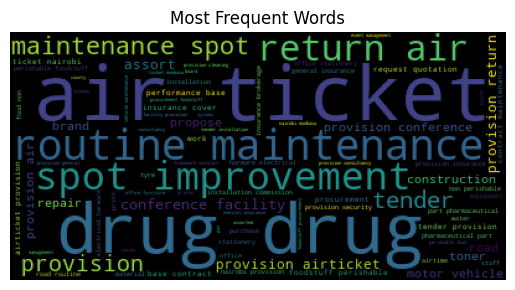

In [164]:
#word cloud
from wordcloud import WordCloud
#Remove rows with missing values in 'Indicator Name' column and convert to strings
cleaned_text = ppra_clean['tender-title'].dropna().astype(str)
# Concatenate all texts into a single string
text_combined = ' '.join(cleaned_text)
# Generate a word cloud image
wordcloud = WordCloud().generate(text_combined)
# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud.recolor(random_state=2017))
plt.title('Most Frequent Words')
plt.axis("off")
plt.show()

## Merging the two datasources

In [166]:
#Check similarity between the two datasets
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Assuming 'text1' and 'text2' are your two text datasets
texts = [cleaned_text] + ocha_clean['Indicator Name'].tolist()

# Convert 'texts' to a list of strings
texts = [str(text) for text in texts]

# Vectorize the text data
vectorizer = TfidfVectorizer()
text_vectors = vectorizer.fit_transform(texts)

# Calculate cosine similarity between the text vectors
cos_sim = cosine_similarity(text_vectors[0], text_vectors[1])
print(f"Cosine Similarity between text datasets: {cos_sim[0][0]}")


Cosine Similarity between text datasets: 0.0


In [167]:
import difflib

# Extracting columns of interest
tender_titles = ppra_clean['tender-title']
indicator_names = ocha_clean['Indicator Name']

matches = {}
for title in tender_titles:
    matches[title] = difflib.get_close_matches(title, indicator_names, cutoff=0.8)
    
print("Matches:")
for title, indicators in matches.items():
    if indicators:
        print(title, indicators)
    
rows = []
for title, indicators in matches.items():
    if indicators:
        rows.append({"services": ", ".join([title] + indicators)})
    else:
        rows.append({"services": title})
        
df = pd.DataFrame(rows)
print(df)

Matches:
motor vehicle kbl ['motor vehicle', 'motor vehicle', 'motor vehicle']
motor vehicle tyre ['motor vehicle', 'motor vehicle', 'motor vehicle']
motor vehicle ['motor vehicle', 'motor vehicle', 'motor vehicle']
                                               services
0                                    provision security
1                 office safe bookshelf chairman office
2                                           safety shoe
3                                      promotional item
4                                               airtime
...                                                 ...
2506  tender provision medical group life group pers...
2507                         provision clean fumigation
2508                                         food stuff
2509                               provision airtickete
2510  provision maintenance government datum centre ...

[2511 rows x 1 columns]


In [168]:
df['services'] = df['services'].apply(preprocess_text)

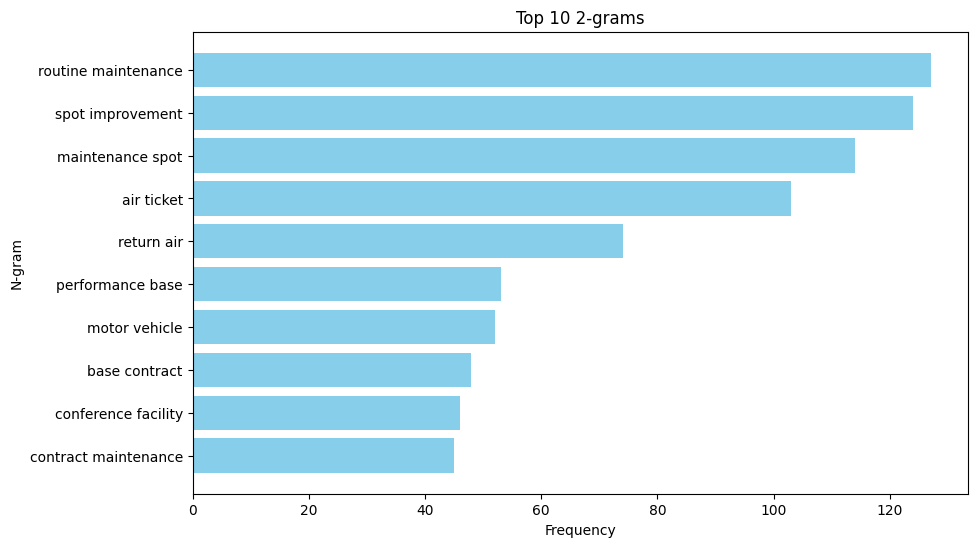

In [169]:
import pandas as pd
from nltk import ngrams, word_tokenize
from collections import Counter
import matplotlib.pyplot as plt

# Function to extract N-grams from text
def extract_ngrams(text, n):
    tokens = word_tokenize(text)  # Tokenize the text
    n_grams = ngrams(tokens, n)  # Generate N-grams
    return [' '.join(gram) for gram in n_grams]  # Join tokens to form N-grams

# Set the value of 'N' for N-grams
N = 2  # Change this value to extract different N-grams (e.g., 2 for bigrams, 3 for trigrams, etc.)

# Extract N-grams from the text Series
ngram_list = df['services'].apply(lambda x: extract_ngrams(x, N))

# Flatten the list of lists into a single list of N-grams
flattened_ngrams = [gram for sublist in ngram_list for gram in sublist]

# Use Counter to count the occurrences of each N-gram
ngram_counts = Counter(flattened_ngrams)

# Convert the ngram_counts into a DataFrame for easier plotting
df_ngrams = pd.DataFrame(ngram_counts.items(), columns=['N-gram', 'Frequency'])

# Sort by frequency in descending order
df_ngrams = df_ngrams.sort_values(by='Frequency', ascending=False)

# Plotting the top N-grams
top_n = 10  # Change this value to visualize a different number of top N-grams
plt.figure(figsize=(10, 6))
plt.barh(df_ngrams['N-gram'][:top_n], df_ngrams['Frequency'][:top_n], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('N-gram')
plt.title(f'Top {top_n} {N}-grams')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

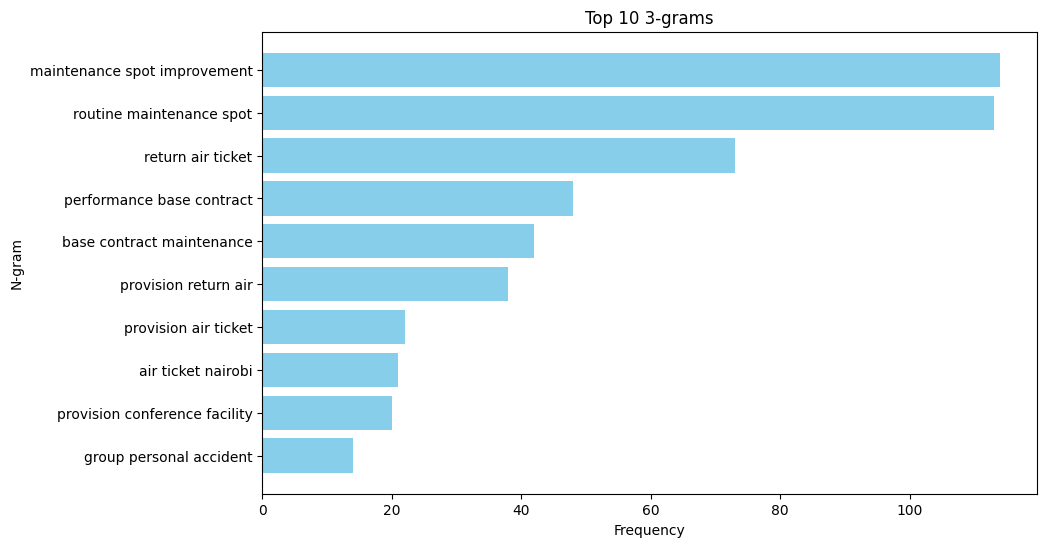

In [170]:
#trigram
# Set the value of 'N' for N-grams
N = 3  # Change this value to extract different N-grams (e.g., 2 for bigrams, 3 for trigrams, etc.)

# Extract N-grams from the text Series
ngram_list = df['services'].apply(lambda x: extract_ngrams(x, N))

# Flatten the list of lists into a single list of N-grams
flattened_ngrams = [gram for sublist in ngram_list for gram in sublist]

# Use Counter to count the occurrences of each N-gram
ngram_counts = Counter(flattened_ngrams)

# Convert the ngram_counts into a DataFrame for easier plotting
df_ngrams = pd.DataFrame(ngram_counts.items(), columns=['N-gram', 'Frequency'])

# Sort by frequency in descending order
df_ngrams = df_ngrams.sort_values(by='Frequency', ascending=False)

# Plotting the top N-grams
top_n = 10  # Change this value to visualize a different number of top N-grams
plt.figure(figsize=(10, 6))
plt.barh(df_ngrams['N-gram'][:top_n], df_ngrams['Frequency'][:top_n], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('N-gram')
plt.title(f'Top {top_n} {N}-grams')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

In [171]:
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer


# Split services into separate words
def split_words(x):
    return str(x).split(', ')

df['services'] = df['services'].apply(split_words)

# Join services back to strings
df['services'] = df['services'].apply(' '.join)

# Create CountVectorizer to generate word counts and fit_transform on 'services'
cv = CountVectorizer(analyzer='word')
X = cv.fit_transform(df['services'])

# Get feature names from CountVectorizer's vocabulary_
feature_names = cv.get_feature_names_out()

# Create and fit LDA model
lda = LatentDirichletAllocation(n_components=12, random_state=42)
lda_transformed = lda.fit_transform(X)

# Print topics and their top 5 probable words
print("LDA Topics:")
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-6:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic {topic_idx + 1}: {' '.join(top_words)}")

# Print document topics
print("\nDocument Topics:")
for doc_topics in lda_transformed:
    print(", ".join(f"{topic * 100:.1f}%" for topic in doc_topics))


LDA Topics:
Topic 1: provision air ticket return conference
Topic 2: installation commission tender testing item
Topic 3: brand hire board chair card
Topic 4: assort office quotation request stationery
Topic 5: maintenance contract vehicle base motor
Topic 6: provision clean propose block tender
Topic 7: equipment propose construction house tender
Topic 8: maintenance routine spot improvement road
Topic 9: provision consultancy laptop tender management
Topic 10: water propose construction provision centre
Topic 11: provision insurance cover medical staff
Topic 12: print material printer design brand

Document Topics:
69.4%, 2.8%, 2.8%, 2.8%, 2.8%, 2.8%, 2.8%, 2.8%, 2.8%, 2.8%, 2.8%, 2.8%
1.4%, 1.4%, 1.4%, 34.7%, 1.4%, 1.4%, 1.4%, 1.4%, 1.4%, 1.4%, 1.4%, 51.4%
2.8%, 2.8%, 2.8%, 2.8%, 69.4%, 2.8%, 2.8%, 2.8%, 2.8%, 2.8%, 2.8%, 2.8%
2.8%, 36.1%, 36.1%, 2.8%, 2.8%, 2.8%, 2.8%, 2.8%, 2.8%, 2.8%, 2.8%, 2.8%
4.2%, 4.2%, 4.2%, 4.2%, 4.2%, 54.2%, 4.2%, 4.2%, 4.2%, 4.2%, 4.2%, 4.2%
1.7%, 1.7%, 1

In [172]:
print("Vocabulary:")
print(feature_names)
print("\nBag-of-words:")
print(X.toarray())

Vocabulary:
['aanmer' 'abaqmadobe' 'abc' ... 'zoology' 'zowerani' 'zrergefnknmanual']

Bag-of-words:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


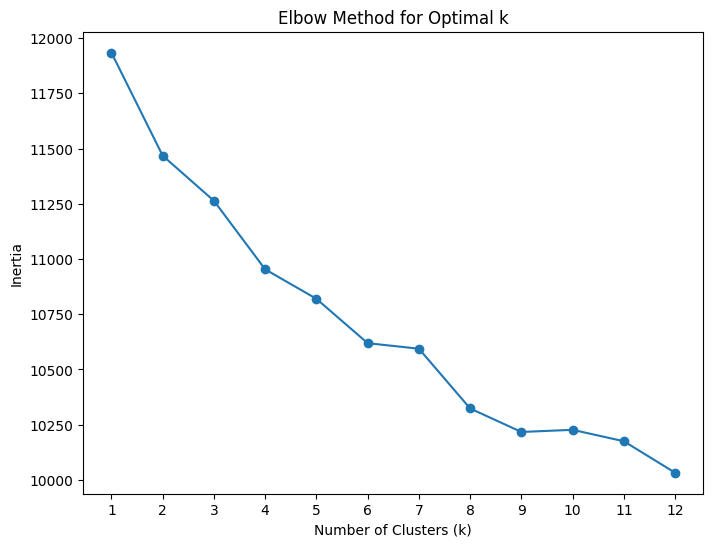

In [173]:

#Kmeans clusterring
from sklearn.cluster import KMeans
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['services'])

# Define range of clusters to try
max_clusters = 12  # Maximum number of clusters to test
inertia_values = []

# Calculate inertia for different values of k
for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Plotting the Elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, max_clusters + 1), inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(1, max_clusters + 1))
plt.show()

In [174]:
from sklearn.cluster import KMeans

# Experimenting with different hyperparameters
# Initialize centroids using different methods
init_methods = ['k-means++', 'random']  # 'k-means++' is the default

for method in init_methods:
    kmeans = KMeans(n_clusters=5, init=method, random_state=42, max_iter=300)
    kmeans.fit(X)
    print(f"Init Method: {method}")
    print(f"Inertia (WCSS): {kmeans.inertia_}")  # Display within-cluster sum of squares (WCSS)
    print(f"Labels: {kmeans.labels_}")  # Display cluster labels
    print("------")

# Varying max_iter for convergence
max_iterations = [50, 100, 200]  # Try different values for max_iter

for iterations in max_iterations:
    kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42, max_iter=iterations)
    kmeans.fit(X)
    print(f"Max Iterations: {iterations}")
    print(f"Inertia (WCSS): {kmeans.inertia_}")  # Display within-cluster sum of squares (WCSS)
    print(f"Labels: {kmeans.labels_}")  # Display cluster labels
    print("------")

# Setting random_state for reproducibility
kmeans = KMeans(n_clusters=10, init='k-means++', random_state=42, max_iter=300)
kmeans.fit(X)
print(f"Random State: 42")
print(f"Inertia (WCSS): {kmeans.inertia_}")  # Display within-cluster sum of squares (WCSS)
print(f"Labels: {kmeans.labels_}")  # Display cluster labels


Init Method: k-means++
Inertia (WCSS): 10617.0518345015
Labels: [0 1 1 ... 1 0 0]
------
Init Method: random
Inertia (WCSS): 10941.171892904807
Labels: [2 1 1 ... 1 2 2]
------
Max Iterations: 50
Inertia (WCSS): 10617.0518345015
Labels: [0 1 1 ... 1 0 0]
------
Max Iterations: 100
Inertia (WCSS): 10617.0518345015
Labels: [0 1 1 ... 1 0 0]
------
Max Iterations: 200
Inertia (WCSS): 10617.0518345015
Labels: [0 1 1 ... 1 0 0]
------
Random State: 42
Inertia (WCSS): 10160.272252843124
Labels: [9 8 8 ... 8 9 9]


c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\hp\anaconda3\en

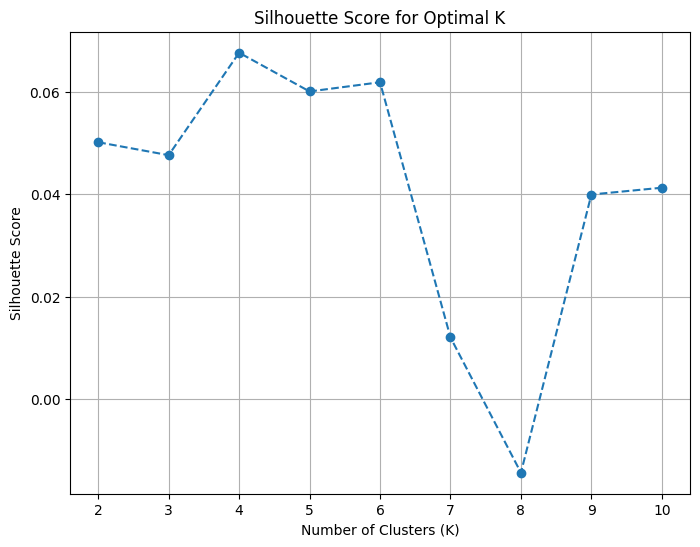

In [175]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Score for different values of K
silhouette_scores = []
for i in range(2, 11):  # Trying K values from 2 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

# Plotting Silhouette Scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()


In [176]:
from sklearn.metrics import silhouette_score
# Average silhouette score
score = silhouette_score(X, labels)
print("Silhouette Score:", score)

Silhouette Score: 0.04127409725251743


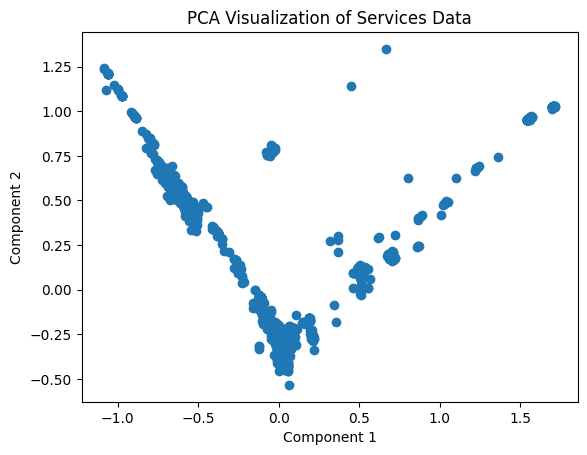

In [177]:
from sklearn.decomposition import PCA
# Apply PCA
pca = PCA(n_components=10)
pca_transformed = pca.fit_transform(X.toarray())

# Visualize transformed data  
plt.scatter(pca_transformed[:,0], pca_transformed[:,1])
plt.title('PCA Visualization of Services Data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')


plt.show()

Model Testing

In [178]:
testing_data=pd.read_csv('Kenya_dataset1.csv')
testing_data.head()

,Text,Category,Label
0,Is government gonna be taxed for it's idle lan...,Agriculture,9
1,I agree Gava should not talk of youth entrepre...,"Industry, Trade and Cooperatives",11
2,Huyu ameamua kuharibu barabara smh,Transport,2
3,Hakuna maji,Water and sanitation,6
4,Lack of water,Water and sanitation,6


In [179]:
testing_data['Text']=testing_data['Text'].apply(preprocess_text)

In [180]:
text_test_data=testing_data['Text']

In [181]:
test_lables=testing_data['Label']

In [182]:
# Vectorize the preprocessed text data using the trained vectorizer
test_tfidf_data = vectorizer.transform(text_test_data)

# Predict labels for the testing data using the trained KMeans model
predicted_labels = km.predict(test_tfidf_data)


In [183]:
from sklearn.metrics import adjusted_rand_score, silhouette_score
# Evaluate Adjusted Rand Index (ARI)
ari = adjusted_rand_score(test_lables, predicted_labels)
print(f"Adjusted Rand Index (ARI): {ari}")

# Evaluate Silhouette Score
# Silhouette score measures how similar an object is to its own cluster compared to other clusters
silhouette = silhouette_score(test_tfidf_data, predicted_labels)
print(f"Silhouette Score: {silhouette}")

c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Adjusted Rand Index (ARI): 9.44598045228306e-05


Silhouette Score: 0.05259452379903175
